## Импорты

In [1]:
import os
import random
import numpy as np
import pandas as pd
import torch

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    set_seed,
    EarlyStoppingCallback
)
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
from IPython.display import display

SEED = 13
set_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2026-01-25 12:23:15.398403: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Device: cuda


## Загрузка датасета AG News

In [2]:
from datasets import DatasetDict

dataset_raw = load_dataset("ag_news")

split = dataset_raw["train"].train_test_split(
    test_size=0.1,
    seed=SEED,
    stratify_by_column="label",
)

dataset = DatasetDict({
    "train": split["train"],
    "validation": split["test"],
    "test": dataset_raw["test"],
})

print("Train:", len(dataset["train"]))
print("Val  :", len(dataset["validation"]))
print("Test :", len(dataset["test"]))

Train: 108000
Val  : 12000
Test : 7600


Посмотрим примеры и распределение классов.

In [3]:
label_names = ["World", "Sports", "Business", "Sci/Tech"]

print("Train size:", len(dataset["train"]))
print("Val size  :", len(dataset["validation"]))
print("Test size :", len(dataset["test"]))
print("\nExample:")
print(dataset["train"][0])

train_labels = np.array(dataset["train"]["label"])
unique, counts = np.unique(train_labels, return_counts=True)
pd.DataFrame({"label_id": unique, "label": [label_names[i] for i in unique], "count": counts})

Train size: 108000
Val size  : 12000
Test size : 7600

Example:
{'text': 'Auburn focused on clinching spot in SEC championship Tommy Tuberville returns to Mississippi with a trip to Atlanta on the line, and he #39;s bringing his best Auburn team yet. The third-ranked Tigers need one win to lock up a spot in the Southeastern Conference ', 'label': 1}


,label_id,label,count
0,0,World,27000
1,1,Sports,27000
2,2,Business,27000
3,3,Sci/Tech,27000


## Токенизация и подготовка данных

In [4]:
MODEL_NAME = "microsoft/deberta-v3-large"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)  
MAX_LEN = 256

def tokenize_batch(batch):
    return tokenizer(batch["text"], truncation=True, max_length=MAX_LEN)

tokenized = dataset.map(tokenize_batch, batched=True, remove_columns=["text"])
tokenized = tokenized.rename_column("label", "labels")
tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
tokenized

/home/jupyter/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 108000
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 12000
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7600
    })
})

## Модель и метрики

In [5]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=4,
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    f1 = f1_score(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Обучение

In [6]:
args = TrainingArguments(
    output_dir="./agnews_runs",
    report_to="none",
    logging_strategy="steps",
    logging_steps=100,
    evaluation_strategy="epoch",
    save_strategy="epoch",             
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_only_model=True,              
    num_train_epochs=4,
    learning_rate=3e-5,
    weight_decay=0.01,
    lr_scheduler_type="cosine",
    warmup_ratio=0.06,
    label_smoothing_factor=0.0,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=128,
    gradient_accumulation_steps=1,
    
    group_by_length=True,
    fp16=True,
    dataloader_num_workers=4,
    seed=SEED,
    ddp_find_unused_parameters=False,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]

)

train_result = trainer.train()
train_result

  1%|▏         | 100/6752 [00:19<16:42,  6.64it/s]

{'loss': 1.1593, 'grad_norm': 5.1913533210754395, 'learning_rate': 7.389162561576355e-06, 'epoch': 0.06}


  3%|▎         | 200/6752 [00:37<16:30,  6.62it/s]

{'loss': 0.3233, 'grad_norm': 5.801724433898926, 'learning_rate': 1.477832512315271e-05, 'epoch': 0.12}


  4%|▍         | 300/6752 [00:55<16:14,  6.62it/s]

{'loss': 0.2919, 'grad_norm': 7.508536338806152, 'learning_rate': 2.2167487684729063e-05, 'epoch': 0.18}


  6%|▌         | 400/6752 [01:13<15:54,  6.66it/s]

{'loss': 0.2543, 'grad_norm': 3.229433059692383, 'learning_rate': 2.955665024630542e-05, 'epoch': 0.24}


  7%|▋         | 500/6752 [01:31<15:44,  6.62it/s]

{'loss': 0.2664, 'grad_norm': 5.820614814758301, 'learning_rate': 2.9984105383419164e-05, 'epoch': 0.3}


  9%|▉         | 600/6752 [01:49<15:23,  6.66it/s]

{'loss': 0.2438, 'grad_norm': 3.3332278728485107, 'learning_rate': 2.9932292568640654e-05, 'epoch': 0.36}


 10%|█         | 700/6752 [02:06<15:14,  6.62it/s]

{'loss': 0.2426, 'grad_norm': 4.201741695404053, 'learning_rate': 2.9844619813982895e-05, 'epoch': 0.41}


 12%|█▏        | 800/6752 [02:24<14:55,  6.64it/s]

{'loss': 0.2469, 'grad_norm': 6.4938554763793945, 'learning_rate': 2.97227206621045e-05, 'epoch': 0.47}


 13%|█▎        | 900/6752 [02:42<14:41,  6.64it/s]

{'loss': 0.2181, 'grad_norm': 6.000965595245361, 'learning_rate': 2.9562622282545614e-05, 'epoch': 0.53}


 15%|█▍        | 1000/6752 [03:00<14:25,  6.65it/s]

{'loss': 0.2007, 'grad_norm': 5.997777938842773, 'learning_rate': 2.936684179547048e-05, 'epoch': 0.59}


 16%|█▋        | 1100/6752 [03:18<14:10,  6.65it/s]

{'loss': 0.202, 'grad_norm': 3.2768959999084473, 'learning_rate': 2.9135858912585805e-05, 'epoch': 0.65}


 18%|█▊        | 1200/6752 [03:36<13:59,  6.61it/s]

{'loss': 0.2103, 'grad_norm': 3.88785457611084, 'learning_rate': 2.8870239600370824e-05, 'epoch': 0.71}


 19%|█▉        | 1300/6752 [03:54<13:41,  6.64it/s]

{'loss': 0.1904, 'grad_norm': 4.160987377166748, 'learning_rate': 2.857063469331624e-05, 'epoch': 0.77}


 21%|██        | 1400/6752 [04:11<13:22,  6.67it/s]

{'loss': 0.1947, 'grad_norm': 3.0568904876708984, 'learning_rate': 2.8237778299215197e-05, 'epoch': 0.83}


 22%|██▏       | 1500/6752 [04:29<13:09,  6.65it/s]

{'loss': 0.1746, 'grad_norm': 3.0199990272521973, 'learning_rate': 2.7872486000413457e-05, 'epoch': 0.89}


 24%|██▎       | 1600/6752 [04:47<12:56,  6.63it/s]

{'loss': 0.1965, 'grad_norm': 3.906229257583618, 'learning_rate': 2.7475652855426424e-05, 'epoch': 0.95}


 99%|█████████▉| 93/94 [00:19<00:00,  4.31it/s]
                                                   
100%|██████████| 94/94 [00:19<00:00,  4.79it/s]
                                               

{'eval_loss': 0.1708950251340866, 'eval_accuracy': 0.9429166666666666, 'eval_f1': 0.9427989248894102, 'eval_runtime': 20.3225, 'eval_samples_per_second': 590.479, 'eval_steps_per_second': 4.625, 'epoch': 1.0}


 25%|██▌       | 1700/6752 [06:08<46:35,  1.81it/s]   

{'loss': 0.179, 'grad_norm': 1.4851770401000977, 'learning_rate': 2.7048251205819437e-05, 'epoch': 1.01}


 27%|██▋       | 1800/6752 [06:26<14:58,  5.51it/s]

{'loss': 0.1485, 'grad_norm': 3.595224142074585, 'learning_rate': 2.6591328293724982e-05, 'epoch': 1.07}


 28%|██▊       | 1900/6752 [06:44<14:44,  5.49it/s]

{'loss': 0.1411, 'grad_norm': 0.9361297488212585, 'learning_rate': 2.6106003695834654e-05, 'epoch': 1.13}


 30%|██▉       | 2001/6752 [07:02<14:20,  5.52it/s]

{'loss': 0.1457, 'grad_norm': 1.6202067136764526, 'learning_rate': 2.55934665801531e-05, 'epoch': 1.18}


 31%|███       | 2100/6752 [07:20<14:09,  5.48it/s]

{'loss': 0.1455, 'grad_norm': 2.7342042922973633, 'learning_rate': 2.5054972792235672e-05, 'epoch': 1.24}


 33%|███▎      | 2200/6752 [07:37<13:50,  5.48it/s]

{'loss': 0.1361, 'grad_norm': 1.2400321960449219, 'learning_rate': 2.4491841778049212e-05, 'epoch': 1.3}


 34%|███▍      | 2301/6752 [07:55<13:24,  5.53it/s]

{'loss': 0.148, 'grad_norm': 1.2612314224243164, 'learning_rate': 2.3905453350995744e-05, 'epoch': 1.36}


 36%|███▌      | 2401/6752 [08:13<13:03,  5.55it/s]

{'loss': 0.1394, 'grad_norm': 2.8541884422302246, 'learning_rate': 2.3297244311020644e-05, 'epoch': 1.42}


 37%|███▋      | 2500/6752 [08:31<12:59,  5.46it/s]

{'loss': 0.1444, 'grad_norm': 2.7500743865966797, 'learning_rate': 2.266870492408947e-05, 'epoch': 1.48}


 39%|███▊      | 2600/6752 [08:49<12:37,  5.48it/s]

{'loss': 0.1419, 'grad_norm': 3.1925582885742188, 'learning_rate': 2.2021375270659404e-05, 'epoch': 1.54}


 40%|███▉      | 2700/6752 [09:07<12:09,  5.55it/s]

{'loss': 0.1279, 'grad_norm': 2.070237636566162, 'learning_rate': 2.1356841472092655e-05, 'epoch': 1.6}


 41%|████▏     | 2800/6752 [09:24<11:59,  5.49it/s]

{'loss': 0.1393, 'grad_norm': 2.0175461769104004, 'learning_rate': 2.0676731804257993e-05, 'epoch': 1.66}


 43%|████▎     | 2900/6752 [09:42<11:46,  5.45it/s]

{'loss': 0.1314, 'grad_norm': 1.0734624862670898, 'learning_rate': 1.998271270784306e-05, 'epoch': 1.72}


 44%|████▍     | 3001/6752 [10:01<11:18,  5.53it/s]

{'loss': 0.144, 'grad_norm': 2.5414886474609375, 'learning_rate': 1.9276484705153265e-05, 'epoch': 1.78}


 46%|████▌     | 3100/6752 [10:18<11:07,  5.47it/s]

{'loss': 0.1362, 'grad_norm': 0.9072617292404175, 'learning_rate': 1.8559778233402044e-05, 'epoch': 1.84}


 47%|████▋     | 3200/6752 [10:36<10:46,  5.50it/s]

{'loss': 0.1287, 'grad_norm': 1.2845631837844849, 'learning_rate': 1.7834349404702066e-05, 'epoch': 1.9}


 49%|████▉     | 3301/6752 [10:54<10:22,  5.54it/s]

{'loss': 0.1305, 'grad_norm': 1.3159394264221191, 'learning_rate': 1.7109327936973477e-05, 'epoch': 1.95}


 99%|█████████▉| 93/94 [00:19<00:00,  4.29it/s]
                                                   
100%|██████████| 94/94 [00:19<00:00,  4.80it/s]
                                               

{'eval_loss': 0.16518935561180115, 'eval_accuracy': 0.9478333333333333, 'eval_f1': 0.9477521554879125, 'eval_runtime': 20.3109, 'eval_samples_per_second': 590.815, 'eval_steps_per_second': 4.628, 'epoch': 2.0}


 50%|█████     | 3400/6752 [12:13<09:43,  5.75it/s]   

{'loss': 0.1126, 'grad_norm': 0.7908591628074646, 'learning_rate': 1.6371846439192513e-05, 'epoch': 2.01}


 52%|█████▏    | 3500/6752 [12:30<09:07,  5.94it/s]

{'loss': 0.0802, 'grad_norm': 0.6948273181915283, 'learning_rate': 1.56310035706921e-05, 'epoch': 2.07}


 53%|█████▎    | 3600/6752 [12:48<08:48,  5.96it/s]

{'loss': 0.082, 'grad_norm': 0.7868625521659851, 'learning_rate': 1.4888614583861088e-05, 'epoch': 2.13}


 55%|█████▍    | 3700/6752 [13:06<08:47,  5.79it/s]

{'loss': 0.0885, 'grad_norm': 3.5287718772888184, 'learning_rate': 1.4146498519469266e-05, 'epoch': 2.19}


 56%|█████▋    | 3800/6752 [13:24<08:15,  5.95it/s]

{'loss': 0.0847, 'grad_norm': 1.3546735048294067, 'learning_rate': 1.3406473749557433e-05, 'epoch': 2.25}


 58%|█████▊    | 3901/6752 [13:42<08:02,  5.91it/s]

{'loss': 0.0804, 'grad_norm': 8.576390266418457, 'learning_rate': 1.2670353521966003e-05, 'epoch': 2.31}


 59%|█████▉    | 4000/6752 [14:00<07:43,  5.94it/s]

{'loss': 0.0844, 'grad_norm': 3.395785331726074, 'learning_rate': 1.1939941517419245e-05, 'epoch': 2.37}


 61%|██████    | 4100/6752 [14:18<07:27,  5.93it/s]

{'loss': 0.0777, 'grad_norm': 0.9662622809410095, 'learning_rate': 1.1217027430051341e-05, 'epoch': 2.43}


 62%|██████▏   | 4200/6752 [14:35<07:16,  5.85it/s]

{'loss': 0.0861, 'grad_norm': 1.3597769737243652, 'learning_rate': 1.0503382582203137e-05, 'epoch': 2.49}


 64%|██████▎   | 4300/6752 [14:53<06:52,  5.95it/s]

{'loss': 0.0692, 'grad_norm': 1.6953598260879517, 'learning_rate': 9.800755584234461e-06, 'epoch': 2.55}


 65%|██████▌   | 4400/6752 [15:11<06:35,  5.95it/s]

{'loss': 0.0763, 'grad_norm': 1.2949453592300415, 'learning_rate': 9.110868049986477e-06, 'epoch': 2.61}


 67%|██████▋   | 4500/6752 [15:29<06:18,  5.94it/s]

{'loss': 0.0729, 'grad_norm': 0.9277762174606323, 'learning_rate': 8.435410378392392e-06, 'epoch': 2.67}


 68%|██████▊   | 4600/6752 [15:47<06:00,  5.98it/s]

{'loss': 0.0735, 'grad_norm': 1.321336030960083, 'learning_rate': 7.77603761157257e-06, 'epoch': 2.73}


 70%|██████▉   | 4700/6752 [16:05<05:45,  5.94it/s]

{'loss': 0.0802, 'grad_norm': 4.511880874633789, 'learning_rate': 7.134365379562755e-06, 'epoch': 2.78}


 71%|███████   | 4801/6752 [16:23<05:29,  5.92it/s]

{'loss': 0.07, 'grad_norm': 1.1066696643829346, 'learning_rate': 6.511965941611907e-06, 'epoch': 2.84}


 73%|███████▎  | 4900/6752 [16:40<05:12,  5.93it/s]

{'loss': 0.0623, 'grad_norm': 1.2060788869857788, 'learning_rate': 5.9103643337493915e-06, 'epoch': 2.9}


 74%|███████▍  | 5000/6752 [16:58<04:55,  5.94it/s]

{'loss': 0.0863, 'grad_norm': 2.548764705657959, 'learning_rate': 5.3310346320610445e-06, 'epoch': 2.96}


 99%|█████████▉| 93/94 [00:19<00:00,  4.30it/s]
                                                   
100%|██████████| 94/94 [00:19<00:00,  4.77it/s]
                                               

{'eval_loss': 0.17569060623645782, 'eval_accuracy': 0.949, 'eval_f1': 0.9488939639144914, 'eval_runtime': 20.3053, 'eval_samples_per_second': 590.98, 'eval_steps_per_second': 4.629, 'epoch': 3.0}


 76%|███████▌  | 5100/6752 [18:13<04:24,  6.25it/s]  

{'loss': 0.0616, 'grad_norm': 0.37008118629455566, 'learning_rate': 4.775396340829954e-06, 'epoch': 3.02}


 77%|███████▋  | 5200/6752 [18:31<04:09,  6.23it/s]

{'loss': 0.0419, 'grad_norm': 0.8276321887969971, 'learning_rate': 4.244810914391956e-06, 'epoch': 3.08}


 78%|███████▊  | 5300/6752 [18:49<03:53,  6.23it/s]

{'loss': 0.0428, 'grad_norm': 0.5096697211265564, 'learning_rate': 3.740578421228224e-06, 'epoch': 3.14}


 80%|███████▉  | 5400/6752 [19:07<03:37,  6.22it/s]

{'loss': 0.0405, 'grad_norm': 4.4709014892578125, 'learning_rate': 3.2639343584686834e-06, 'epoch': 3.2}


 81%|████████▏ | 5500/6752 [19:25<03:20,  6.25it/s]

{'loss': 0.0439, 'grad_norm': 1.0323209762573242, 'learning_rate': 2.816046624611588e-06, 'epoch': 3.26}


 83%|████████▎ | 5600/6752 [19:43<03:05,  6.21it/s]

{'loss': 0.0438, 'grad_norm': 1.8244928121566772, 'learning_rate': 2.3980126578768208e-06, 'epoch': 3.32}


 84%|████████▍ | 5701/6752 [20:01<02:48,  6.23it/s]

{'loss': 0.0424, 'grad_norm': 0.3006904721260071, 'learning_rate': 2.0108567472047355e-06, 'epoch': 3.38}


 86%|████████▌ | 5800/6752 [20:19<02:32,  6.23it/s]

{'loss': 0.035, 'grad_norm': 0.595999002456665, 'learning_rate': 1.6555275224891835e-06, 'epoch': 3.44}


 87%|████████▋ | 5900/6752 [20:36<02:16,  6.24it/s]

{'loss': 0.0473, 'grad_norm': 0.5821572542190552, 'learning_rate': 1.33289563019438e-06, 'epoch': 3.5}


 89%|████████▉ | 6000/6752 [20:54<02:00,  6.24it/s]

{'loss': 0.0372, 'grad_norm': 0.405961275100708, 'learning_rate': 1.0437516000508718e-06, 'epoch': 3.55}


 90%|█████████ | 6100/6752 [21:12<01:44,  6.24it/s]

{'loss': 0.0396, 'grad_norm': 1.8749103546142578, 'learning_rate': 7.888039080577625e-07, 'epoch': 3.61}


 92%|█████████▏| 6200/6752 [21:30<01:28,  6.23it/s]

{'loss': 0.0392, 'grad_norm': 0.07901772111654282, 'learning_rate': 5.686772405373542e-07, 'epoch': 3.67}


 93%|█████████▎| 6300/6752 [21:48<01:12,  6.23it/s]

{'loss': 0.0446, 'grad_norm': 0.19864721596240997, 'learning_rate': 3.8391096349566166e-07, 'epoch': 3.73}


 95%|█████████▍| 6401/6752 [22:06<00:56,  6.22it/s]

{'loss': 0.0404, 'grad_norm': 0.8119143843650818, 'learning_rate': 2.34957801039295e-07, 'epoch': 3.79}


 96%|█████████▋| 6500/6752 [22:24<00:40,  6.21it/s]

{'loss': 0.0282, 'grad_norm': 0.5466060042381287, 'learning_rate': 1.2218272608690628e-07, 'epoch': 3.85}


 98%|█████████▊| 6600/6752 [22:42<00:24,  6.22it/s]

{'loss': 0.0413, 'grad_norm': 3.5603737831115723, 'learning_rate': 4.5862066093228514e-08, 'epoch': 3.91}


 99%|█████████▉| 6701/6752 [23:00<00:08,  6.19it/s]

{'loss': 0.0323, 'grad_norm': 0.1897820383310318, 'learning_rate': 6.1828259769369784e-09, 'epoch': 3.97}


 99%|█████████▉| 93/94 [00:19<00:00,  4.30it/s]
                                                   
100%|██████████| 94/94 [00:19<00:00,  4.81it/s]
                                               

{'eval_loss': 0.20588038861751556, 'eval_accuracy': 0.94925, 'eval_f1': 0.9491999674780623, 'eval_runtime': 20.3033, 'eval_samples_per_second': 591.038, 'eval_steps_per_second': 4.63, 'epoch': 4.0}


100%|██████████| 6752/6752 [24:34<00:00,  6.25it/s]

{'train_runtime': 1474.9719, 'train_samples_per_second': 292.887, 'train_steps_per_second': 4.578, 'train_loss': 0.13509041551165107, 'epoch': 4.0}


100%|██████████| 6752/6752 [24:35<00:00,  4.58it/s]


TrainOutput(global_step=6752, training_loss=0.13509041551165107, metrics={'train_runtime': 1474.9719, 'train_samples_per_second': 292.887, 'train_steps_per_second': 4.578, 'train_loss': 0.13509041551165107, 'epoch': 4.0})

## Визуализация обучения (loss, accuracy, F1)

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
65,0.0446,0.198647,3.839110e-07,3.73,6300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,0.0404,0.811914,2.349578e-07,3.79,6400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,0.0282,0.546606,1.221827e-07,3.85,6500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,0.0413,3.560374,4.586207e-08,3.91,6600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,0.0323,0.189782,6.182826e-09,3.97,6700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
16,NaN,NaN,NaN,1.0,1688,0.170895,0.942917,0.942799,20.3225,590.479,4.625,NaN,NaN,NaN,NaN,NaN
34,NaN,NaN,NaN,2.0,3376,0.165189,0.947833,0.947752,20.3109,590.815,4.628,NaN,NaN,NaN,NaN,NaN
52,NaN,NaN,NaN,3.0,5064,0.175691,0.949000,0.948894,20.3053,590.980,4.629,NaN,NaN,NaN,NaN,NaN
70,NaN,NaN,NaN,4.0,6752,0.205880,0.949250,0.949200,20.3033,591.038,4.630,NaN,NaN,NaN,NaN,NaN


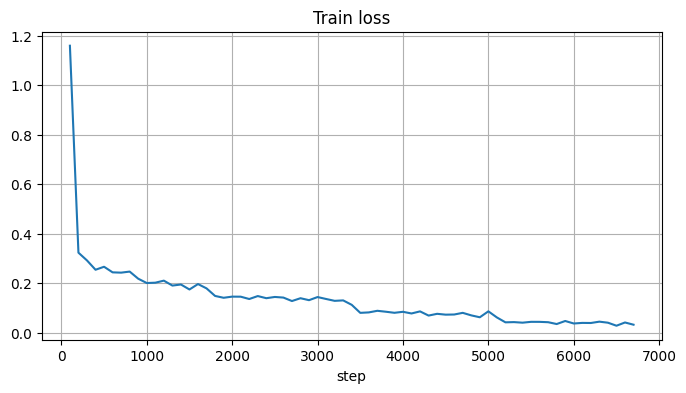

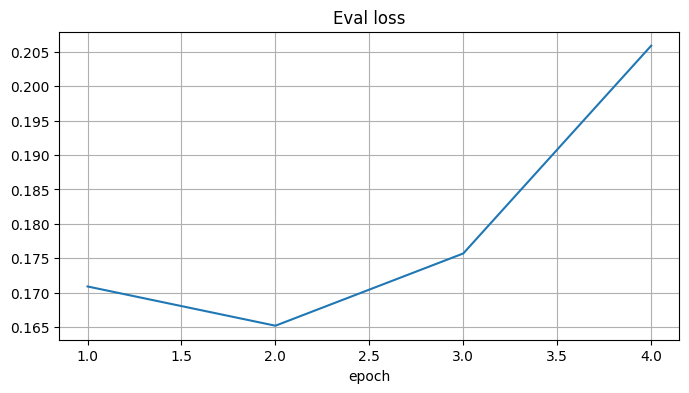

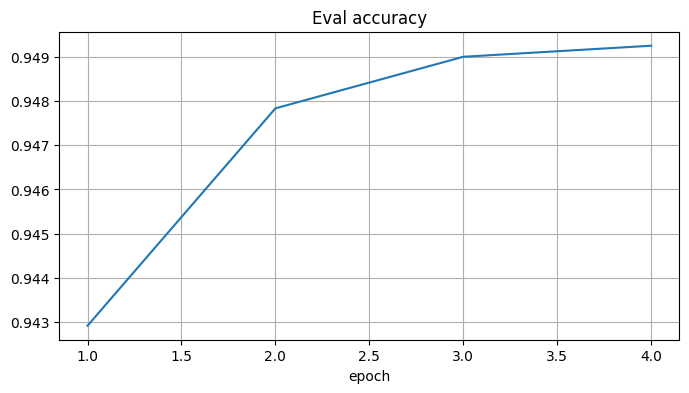

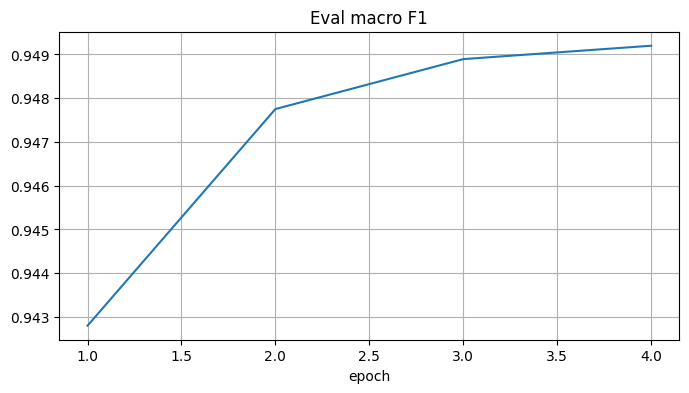

In [7]:
log_history = trainer.state.log_history
df_logs = pd.DataFrame(log_history)

df_train = df_logs[df_logs["loss"].notna() & df_logs["eval_loss"].isna()].copy()
df_eval = df_logs[df_logs["eval_loss"].notna()].copy()

display(df_train.tail())
display(df_eval.tail())

def plot_metric(x, y, title, xlabel="step"):
    plt.figure(figsize=(8, 4))
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.grid(True)
    plt.show()

if len(df_train) > 0:
    plot_metric(df_train["step"], df_train["loss"], "Train loss", xlabel="step")

if len(df_eval) > 0:
    plot_metric(df_eval["epoch"], df_eval["eval_loss"], "Eval loss", xlabel="epoch")
    if "eval_accuracy" in df_eval.columns:
        plot_metric(df_eval["epoch"], df_eval["eval_accuracy"], "Eval accuracy", xlabel="epoch")
    if "eval_f1" in df_eval.columns:
        plot_metric(df_eval["epoch"], df_eval["eval_f1"], "Eval macro F1", xlabel="epoch")

## Оценка на test выборке (Macro F1)

In [8]:
pred = trainer.predict(tokenized["test"])
test_logits = pred.predictions
test_labels = pred.label_ids
test_preds = np.argmax(test_logits, axis=-1)

test_f1 = f1_score(test_labels, test_preds, average="macro")
test_acc = accuracy_score(test_labels, test_preds)

print(f"Test macro F1: {test_f1:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

print("\nClassification report:")
print(classification_report(test_labels, test_preds, target_names=label_names, digits=4))

100%|██████████| 60/60 [00:11<00:00,  5.08it/s]

Test macro F1: 0.9506
Test accuracy: 0.9507

Classification report:
              precision    recall  f1-score   support

       World     0.9523    0.9663    0.9592      1900
      Sports     0.9900    0.9921    0.9911      1900
    Business     0.9321    0.9174    0.9247      1900
    Sci/Tech     0.9278    0.9268    0.9273      1900

    accuracy                         0.9507      7600
   macro avg     0.9506    0.9507    0.9506      7600
weighted avg     0.9506    0.9507    0.9506      7600



## Confusion matrix на test выборке

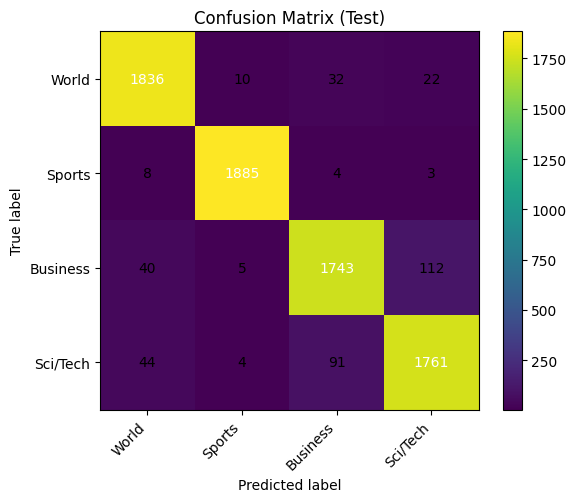

In [9]:
cm = confusion_matrix(test_labels, test_preds, labels=[0,1,2,3])

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Test)")
plt.colorbar()
tick_marks = np.arange(len(label_names))
plt.xticks(tick_marks, label_names, rotation=45, ha="right")
plt.yticks(tick_marks, label_names)

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], "d"),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()